In [1]:
import numpy as np
import pandas as pd
import numpy_groupies as npg

import os
import sys
import glob 
import itertools
import string
import pickle

from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.preprocessing import LabelEncoder

import tqdm.notebook as tqdm

from utils.vis_3d import BrainSurface
from utils.plot import draw_four_views, get_img_from_fig
from utils.colors import blues_fixed_r, blues_fixed, reds_fixed
from utils.stats import jk_pacf_diff_sign

In [2]:
import cupy as cp

def get_arr(x, baseline_correct=False, baseline_size=1000):
    if type(x) is cp.ndarray:
        res = x.get()
    else:
        res = x
    
    if baseline_correct:
        res -= res[..., :baseline_size].mean(axis=-1, keepdims=True)

    return res

In [4]:
submission_data_path = os.path.join('..', '..', 'meso_submission_data')
fsaverage_path = os.path.join(submission_data_path, 'anatomy', 'fsaverage')


In [5]:
frequencies = np.geomspace(5, 100, 80)
n_frequencies = len(frequencies)

n_samples = 3000
n_parcels = 200

cue_types = {'att' : 0, 'non': 1, 'res': 2}

n_types = len(cue_types)

In [10]:
tsdt_data = pickle.load(open(os.path.join(submission_data_path, 'figure_8', 'tsdt_data.pickle'), 'rb'))
pacf_diff_subjectwise = tsdt_data['pacf_diff_subjectwise']

cohort_pacf_diff = tsdt_data['cohort_pacf_diff']
cohort_amp_diff = tsdt_data['cohort_amp_diff']
cohort_evoked_diff = tsdt_data['cohort_evoked_diff']

hit_avg = tsdt_data['hit_avg']
miss_avg = tsdt_data['miss_avg']

hit_amp_avg = tsdt_data['hit_amp_avg']
miss_amp_avg = tsdt_data['miss_amp_avg']

hit_evoked_avg = tsdt_data['hit_evoked_avg']
miss_evoked_avg = tsdt_data['miss_evoked_avg']

# for key, val in tsdt_data.items():
#     globals()[key] = val



In [12]:
surr_level_parcelwise = np.load(os.path.join(submission_data_path, 'figure_8', 'tsdt_surr_level_parcelwise.npy'))
surr_level_parcelwise_amp = np.load(os.path.join(submission_data_path, 'figure_8', 'tsdt_surr_level_parcelwise_amp.npy'))
surr_level_parcelwise_evoked = np.load(os.path.join(submission_data_path, 'figure_8', 'tsdt_surr_level_parcelwise_evoked.npy'))

In [13]:
jk_sign_pos, jk_sign_neg = jk_pacf_diff_sign(pacf_diff_subjectwise, surr_level_parcelwise[0])


In [14]:
cohort_pacf_diff_sign_pos = (cohort_pacf_diff >= surr_level_parcelwise[0]).transpose(1,0,2)
cohort_pacf_diff_sign_neg = (cohort_pacf_diff <= -surr_level_parcelwise[0]).transpose(1,0,2)

cohort_amp_diff_sign_pos = (cohort_amp_diff >= surr_level_parcelwise_amp[0]).transpose(1,0,2)
cohort_amp_diff_sign_neg = (cohort_amp_diff <= -surr_level_parcelwise_amp[0]).transpose(1,0,2)

cohort_evoked_diff_sign_pos = (cohort_evoked_diff >= surr_level_parcelwise_evoked[0]).transpose(1,0,2)
cohort_evoked_diff_sign_neg = (cohort_evoked_diff <= -surr_level_parcelwise_evoked[0]).transpose(1,0,2)

cohort_pacf_diff_sign_both = cohort_pacf_diff_sign_pos.mean(axis=0) - cohort_pacf_diff_sign_neg.mean(axis=0)


In [17]:
brain_surf_lh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_200Parcels_17Networks_order', 
                             hemis=['lh'], surface='inflated')
brain_surf_rh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_200Parcels_17Networks_order', 
                             hemis=['rh'], surface='inflated')

brain_3d_surfaces = [brain_surf_lh, brain_surf_rh]
parcel_names_fixed = tsdt_data['parcel_names_fixed']
surf_parcel_names = brain_surf_lh.parcel_names[1:] + brain_surf_rh.parcel_names[1:]

parcel_names_matched = sorted(surf_parcel_names)

In [19]:
parcel_subsystems = [p.split('_')[2] for p in parcel_names_fixed]
subsystem_encoder = LabelEncoder().fit(parcel_subsystems)
parcel_subsystem_labels = subsystem_encoder.transform(parcel_subsystems)

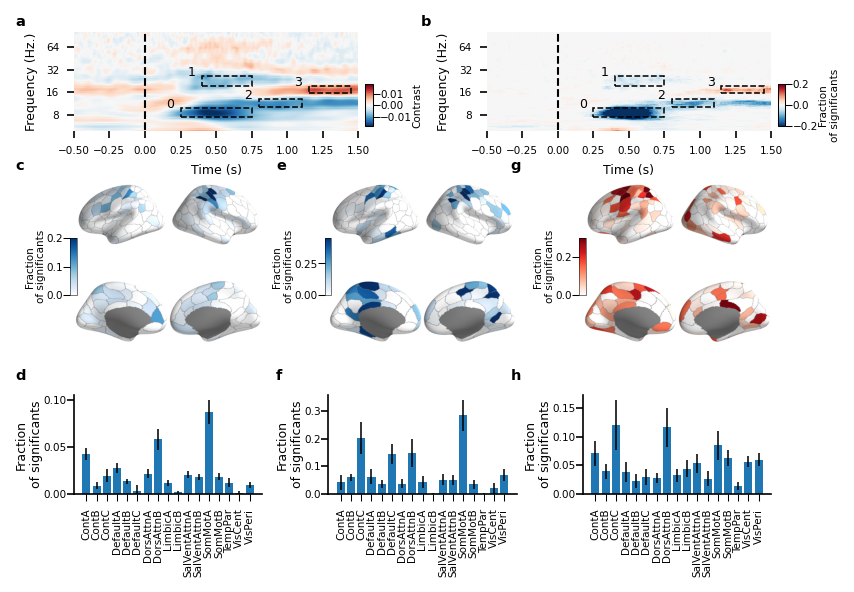

In [20]:
fig = plt.figure(figsize=(6,4), dpi=150, constrained_layout=False)
main_spec = fig.add_gridspec(nrows=3, ncols=1, hspace=0.25, height_ratios=[1,2,1])

gs_top = main_spec[0].subgridspec(ncols=2, nrows=1, wspace=0.45)
gs_brain_cols = main_spec[1].subgridspec(ncols=3, nrows=1, hspace=0.1, wspace=0.35)
gs_bot = main_spec[2].subgridspec(ncols=3, nrows=1, wspace=0.35)

axes = np.empty((6,6), dtype=object)

for i in range(2):
    axes[0,i] = fig.add_subplot(gs_top[i])
        
for i, j in itertools.product(range(1), range(3)):
    brain_gs = gs_brain_cols[i,j].subgridspec(2,2, wspace=0, hspace=0)
    for nr, nc in itertools.product(range(2), range(2)):
        axes[i*2+nr + 1, j*2+nc] = fig.add_subplot(brain_gs[nr,nc])

for i in range(3):
    axes[3,i] = fig.add_subplot(gs_bot[i])


vmax = np.percentile(np.abs(cohort_pacf_diff.mean(axis=1)), 99.9)
vmin = -vmax

imh0 = axes[0, 0].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, cohort_pacf_diff.mean(axis=1), cmap='RdBu_r', vmin=vmin, vmax=vmax, rasterized=True)
imh1 = axes[0, 1].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, cohort_pacf_diff_sign_both, cmap='RdBu_r', vmin=-0.2, vmax=0.2, rasterized=True)


for area_idx, ((f_start, f_end), (t_start, t_end)) in enumerate(zip(zip(frequencies[[11,36,19,30]], frequencies[[18, 44, 25, 36]]), zip([0.25, 0.4, 0.8, 1.15], [0.75, 0.75, 1.1, 1.45]))):
    axes[0,0].add_patch(plt.Rectangle((t_start, f_start), t_end - t_start, f_end - f_start, ls="--", lw=0.75, ec="black", fc="none"))
    axes[0,1].add_patch(plt.Rectangle((t_start, f_start), t_end - t_start, f_end - f_start, ls="--", lw=0.75, ec="black", fc="none"))

    axes[0,0].text(t_start - 0.1, f_end, area_idx, size=6)
    axes[0,1].text(t_start - 0.1, f_end, area_idx, size=6)


cbar_ax0 = inset_axes(axes[0, 0],                  
                 width="2.5%",  # width = 10% of parent_bbox width
                 height="40%",  # height : 50%
                 loc='lower right',
                 bbox_to_anchor=(0, 0.05, 1.05, 1.05),
                 bbox_transform=axes[0, 0].transAxes,
                 borderpad=0,
                 )
cbar_ax1 = inset_axes(axes[0, 1],                  
                 width="2.5%",  # width = 10% of parent_bbox width
                 height="40%",  # height : 50%
                 loc='lower right',
                 bbox_to_anchor=(0, 0.05, 1.05, 1.05),
                 bbox_transform=axes[0,1].transAxes,
                 borderpad=0,) 

            
cbar0 = fig.colorbar(imh0, cax=cbar_ax0)
cbar1 = fig.colorbar(imh1, cax=cbar_ax1)

for cb in [cbar0, cbar1]:
    cb.outline.set_linewidth(0.5)

draw_four_views(axes[1:3, 0:2], cohort_pacf_diff_sign_neg[:, 36:45, 1800:2300].mean(axis=(-1,-2)), parcel_names_matched, brain_3d_surfaces, norm_values=(0, 0.2), cmap=blues_fixed) 
draw_four_views(axes[1:3, 2:4], cohort_pacf_diff_sign_neg[:, 19:25, 2300:2600].mean(axis=(-1,-2)), parcel_names_matched, brain_3d_surfaces, norm_values=(0, 0.45), cmap=blues_fixed) 
draw_four_views(axes[1:3, 4:6], cohort_pacf_diff_sign_pos[:, 30:36, 2650:2950].mean(axis=(-1,-2)), parcel_names_matched, brain_3d_surfaces, norm_values=(0, 0.3), cmap=reds_fixed) 

effect_one_systemwise = npg.aggregate(parcel_subsystem_labels, cohort_pacf_diff_sign_neg[:, 36:45, 1900:2250].mean(axis=(-1,-2)), func='mean')
effect_two_systemwise = npg.aggregate(parcel_subsystem_labels, cohort_pacf_diff_sign_neg[:, 19:25, 2300:2600].mean(axis=(-1,-2)), func='mean')
effect_three_systemwise = npg.aggregate(parcel_subsystem_labels, cohort_pacf_diff_sign_pos[:, 30:36, 2650:2950].mean(axis=(-1,-2)), func='mean')

effect_one_std_systemwise = npg.aggregate(parcel_subsystem_labels, jk_sign_neg[:, 36:45, :, 1900:2250].mean(axis=(-1,-3)), axis=-1, func='mean').std(axis=0)
effect_two_std_systemwise = npg.aggregate(parcel_subsystem_labels, jk_sign_neg[:, 19:25, :, 2300:2600].mean(axis=(-1,-3)), axis=-1, func='mean').std(axis=0)
effect_three_std_systemwise = npg.aggregate(parcel_subsystem_labels, jk_sign_pos[:, 30:36, :, 2650:2950].mean(axis=(-1,-3)), axis=-1, func='mean').std(axis=0)


axes[3,0].bar(subsystem_encoder.classes_, effect_one_systemwise, yerr=effect_one_std_systemwise, error_kw=dict(lw=0.75))
axes[3,1].bar(subsystem_encoder.classes_, effect_two_systemwise, yerr=effect_two_std_systemwise, error_kw=dict(lw=0.75))
axes[3,2].bar(subsystem_encoder.classes_, effect_three_systemwise, yerr=effect_three_std_systemwise, error_kw=dict(lw=0.75))

for ax in axes[3, :3]:
    ax.tick_params(axis='x', rotation=90, width=0.5, labelsize=5)
    ax.tick_params(axis='y', labelsize=5, pad=0.1)
    ax.set_ylabel('Fraction\nof significants', fontsize=6, labelpad=0.0)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    _, ymax = ax.get_ylim()
    ax.set_ylim([0, ymax])

for ax in axes[0, :2]:
    ax.set_yscale('log')

    ax.set_yticks(2**np.arange(2, 7))
    ax.set_yticklabels(2**np.arange(2, 7), fontsize=5)

    ax.yaxis.set_minor_formatter(mticker.NullFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

    ax.minorticks_off()

    ax.set_ylabel('Frequency (Hz.)', fontsize=6)
    ax.set_xlabel('Time (s)', fontsize=6)

    ax.set_xlim([-0.5, 1.5])

    ax.tick_params(labelsize=5)

    ax.plot([0, 0], frequencies[[0,~0]], color='black', ls='--', lw=1)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

cbar_ax0.yaxis.set_tick_params(labelsize=5)
cbar_ax1.yaxis.set_tick_params(labelsize=5)

for ax, label, position in zip(fig.axes[-5:], ['Contrast'] + ['Fraction\nof significants']*4, ['right']*2 + ['left']*3):
    ax.set_ylabel(label, fontsize=5, labelpad=0.0)
    ax.yaxis.set_tick_params(labelsize=5, pad=0, width=0.5) 
    ax.yaxis.set_label_position(position)


for label, (xpos, ypos) in zip(string.ascii_lowercase, itertools.product([0.06, 0.51], [0.89])):
    fig.text(xpos, ypos, label, fontsize=7, weight='bold')

for label, (xpos, ypos) in zip(string.ascii_lowercase[2:], itertools.product([0.06, 0.35, 0.61], [0.65, 0.3])):
    fig.text(xpos, ypos, label, fontsize=7, weight='bold')

fig.savefig('publication_figures/figure_8_tsdt.png', dpi=300, bbox_inches="tight")

for format in ['svg', 'pdf']:
    fig.savefig(f'publication_figures_vector/figure_8.{format}', dpi=300, bbox_inches="tight")

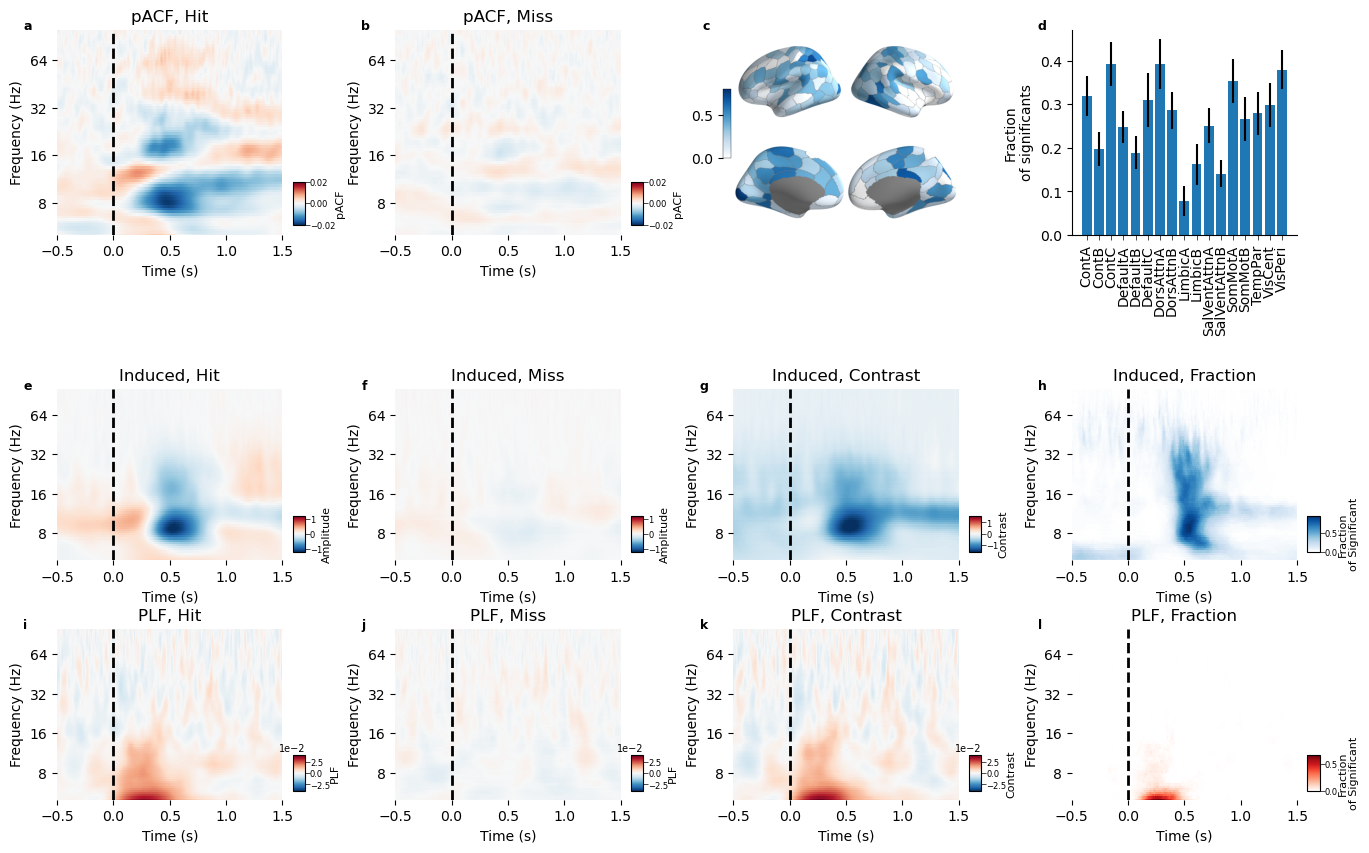

In [21]:
fig = plt.figure(figsize=(16,10),  constrained_layout=False)
main_spec = fig.add_gridspec(nrows=2, ncols=1, hspace=0.5, height_ratios=[1,2])
top_spec = main_spec[0].subgridspec(1, 4, wspace=0.5)
bot_spec = main_spec[1].subgridspec(2, 4, wspace=0.5, hspace=0.4)

axes = np.zeros((3,4), dtype=object)
axes[:] = None

for i in [0,1,3]:
    axes[0,i] = fig.add_subplot(top_spec[i])

for i in range(1,3):
    for j in range(4):
        axes[i,j] = fig.add_subplot(bot_spec[i-1, j])


brain_gs = top_spec[0,2].subgridspec(2,2, wspace=0, hspace=0)
brain_axes = np.zeros((2,2), dtype=object)
for nr, nc in itertools.product(range(2), range(2)):
    brain_axes[nr, nc] = fig.add_subplot(brain_gs[nr,nc])

# axes[0, 2].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, cohort_pacf_diff.mean(axis=1), cmap='RdBu_r', vmin=vmin, vmax=vmax)
# axes[0, 3].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, cohort_pacf_diff_sign_both, cmap='RdBu_r', vmin=-0.3, vmax=0.3)

axes[0, 0].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, (hit_avg - hit_avg[..., :1000].mean(axis=-1, keepdims=True)).mean(axis=1), cmap='RdBu_r', vmin=-0.02, vmax=0.02)
axes[0, 1].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, (miss_avg - miss_avg[..., :1000].mean(axis=-1, keepdims=True)).mean(axis=1), cmap='RdBu_r', vmin=-0.02, vmax=0.02)

axes[1, 2].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, cohort_amp_diff.mean(axis=1)*1e11, cmap='RdBu_r', vmin=-1.6, vmax=1.6)
axes[1, 3].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, cohort_amp_diff_sign_neg.mean(axis=0), cmap=blues_fixed)

axes[1, 0].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, (hit_amp_avg - hit_amp_avg[..., :1000].mean(axis=-1, keepdims=True)).mean(axis=1)*1e11, cmap='RdBu_r', vmin=-1.2, vmax=1.2)
axes[1, 1].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, (miss_amp_avg - miss_amp_avg[..., :1000].mean(axis=-1, keepdims=True)).mean(axis=1)*1e11, cmap='RdBu_r', vmin=-1.2, vmax=1.2)

axes[2, 2].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, cohort_evoked_diff.mean(axis=1), cmap='RdBu_r', vmin=-0.04, vmax=0.04)
axes[2, 3].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, cohort_evoked_diff_sign_pos.mean(axis=0), cmap=reds_fixed)

axes[2, 0].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, (hit_evoked_avg - hit_evoked_avg[..., :1000].mean(axis=-1, keepdims=True)).mean(axis=1), cmap='RdBu_r', vmin=-0.04, vmax=0.04)
axes[2, 1].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, (miss_evoked_avg - miss_evoked_avg[..., :1000].mean(axis=-1, keepdims=True)).mean(axis=1), cmap='RdBu_r', vmin=-0.04, vmax=0.04)

draw_four_views(brain_axes, cohort_pacf_diff_sign_neg[:, 11:18, 1750:2250].mean(axis=(-1,-2)), parcel_names_matched, brain_3d_surfaces, norm_values=(0, 0.8), cmap=blues_fixed) 

effect_one_systemwise = npg.aggregate(parcel_subsystem_labels, cohort_pacf_diff_sign_neg[:, 11:18, 1750:2250].mean(axis=(-1,-2)), func='mean')
effect_one_std_systemwise = npg.aggregate(parcel_subsystem_labels, jk_sign_neg[:, 11:18, :, 1750:2250].mean(axis=(-1,-3)), axis=-1, func='mean').std(axis=0)

axes[0,3].bar(subsystem_encoder.classes_, effect_one_systemwise, yerr=effect_one_std_systemwise)

cbar_axes = np.zeros((3,4), dtype=axes.dtype)
cbar_axes[:] = None

for midx, metric in enumerate(['pACF', 'Induced', 'PLF']):
    for sidx, statistic in enumerate(['Hit', 'Miss', 'Contrast', 'Fraction']):
        if midx == 0 and sidx in (2,3):
            continue

        title = metric + ', ' + statistic
        
        ax = axes[midx, sidx]

        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        ax.set_title(title)
        
        ax.set_yscale('log')

        # ax.set_yticks(frequencies[::10].astype(int))
        # ax.set_yticklabels(frequencies[::10].astype(int))
        ax.set_yticks(2**np.arange(2, 7))
        ax.set_yticklabels(2**np.arange(2, 7))

        ax.plot([0,0], frequencies[[0, ~0]], ls='--', color='black', lw=2)

        ax.set_ylim(frequencies[[0, ~0]])

        ax.set_xlim([-0.5, 1.5])

        ax.yaxis.set_minor_formatter(mticker.NullFormatter())
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

        ax.minorticks_off()

        cbar_axes[midx, sidx] = inset_axes(ax,                  
                    width="5%",  # width = 10% of parent_bbox width
                    height="20%",  # height : 50%
                    loc='lower right',
                    bbox_to_anchor=(0, 0.05, 1.1, 1.05),
                    bbox_transform=ax.transAxes,
                    borderpad=0,
                    )

        fig.colorbar(ax.collections[0], cax=cbar_axes[midx, sidx])

        cbar_axes[midx, sidx].tick_params(labelsize=7)

        if midx == 2 and (sidx < 3):
            cbar_axes[midx, sidx].yaxis.get_major_formatter().set_powerlimits((0,0))
            cbar_axes[midx, sidx].yaxis.get_offset_text().set_fontsize(7)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)


fig.set_facecolor('white') 
# we have to create inset axes AFTER tight_layout()

for ax in [axes[0,3]]:
    ax.tick_params(axis='x', rotation=90, width=0.5)
    ax.set_ylabel('Fraction\nof significants')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    _, ymax = ax.get_ylim()
    ax.set_ylim([0, ymax])

for ax, label in zip(cbar_axes.flatten(), ['pACF']*2 + ['fill', 'fill'] + ['Amplitude']*2 + ['Contrast', 'Fraction\nof Significant'] + ['PLF']*2 + ['Contrast', 'Fraction\nof Significant']):
    if ax is None:
        continue
    ax.set_ylabel(label, fontsize=8, labelpad=0.0)
    ax.yaxis.set_tick_params(labelsize=6, pad=0, width=0.5) 

for ax, label in zip(axes.flatten(), string.ascii_lowercase):
    if ax is None:
        continue
    ax.text(-0.15, 1, label, fontsize=9, transform=ax.transAxes, weight='bold')

brain_axes[0,0].text(-0.27, 1.11, 'c', fontsize=9, transform=brain_axes[0,0].transAxes, weight='bold')

fig.savefig('publication_figures/figure_8_tsdt_supp.png', dpi=300, bbox_inches='tight')

In [22]:
raise RuntimeError('Exception before animation!')

RuntimeError: Exception before animation!

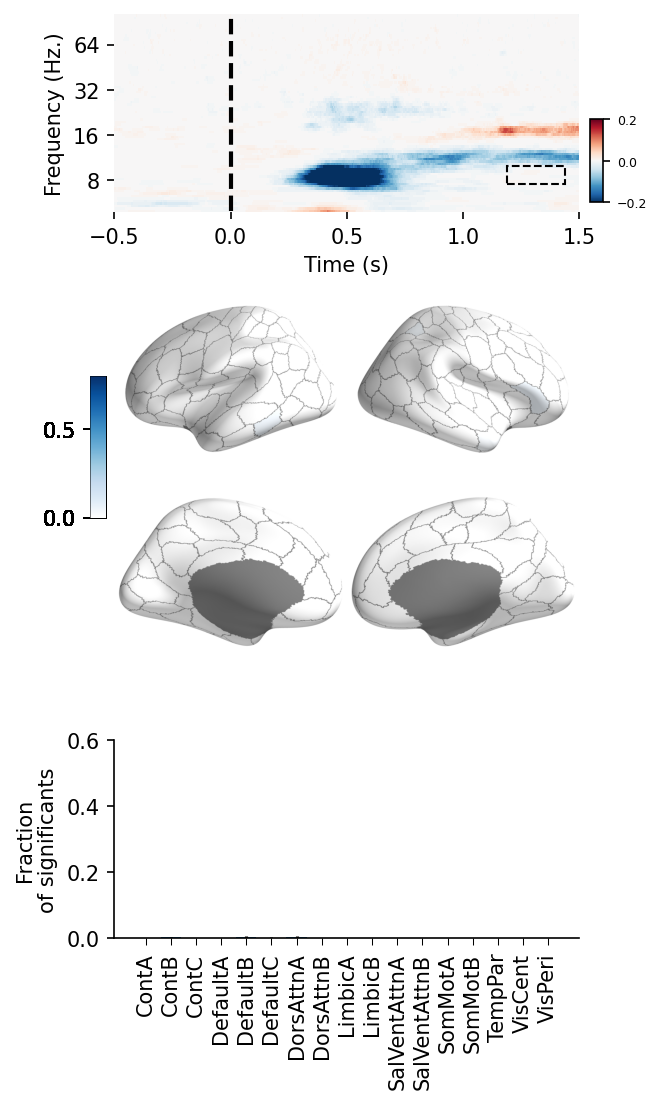

In [ ]:
fig = plt.figure(figsize=(4,8), dpi=150, constrained_layout=False)
main_spec = fig.add_gridspec(nrows=3, ncols=1, hspace=0.25, height_ratios=[1,2,1])

gs_top = main_spec[0].subgridspec(ncols=1, nrows=1, wspace=0.25)
gs_brain_cols = main_spec[1].subgridspec(ncols=1, nrows=1, hspace=0.1, wspace=0.25)
gs_bot = main_spec[2].subgridspec(ncols=1, nrows=1, wspace=0.25)

axes = np.empty((6,6), dtype=object)

for i in range(1):
    axes[0,i] = fig.add_subplot(gs_top[i])
        
for i, j in itertools.product(range(1), range(1)):
    brain_gs = gs_brain_cols[i,j].subgridspec(2,2, wspace=0, hspace=0)
    for nr, nc in itertools.product(range(2), range(2)):
        axes[i*2+nr + 1, j*2+nc] = fig.add_subplot(brain_gs[nr,nc])

for i in range(1):
    axes[3,i] = fig.add_subplot(gs_bot[i])

cbar_ax0 = inset_axes(axes[0,0],                  
                 width="2.5%",  # width = 10% of parent_bbox width
                 height="40%",  # height : 50%
                 loc='lower right',
                 bbox_to_anchor=(0, 0.05, 1.05, 1.05),
                 bbox_transform=axes[0, 0].transAxes,
                 borderpad=0,
                 )


window_size = 0.25

images_list = list()

for t_start in np.arange(0, 1.2, 0.01):
    for ax in axes.flatten():
        if not(ax is None):
            ax.clear()

    sample_start = 1500 + int(t_start*1000)
    sample_end = sample_start + int(window_size*1000)

    imh0 = axes[0, 0].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, cohort_pacf_diff_sign_both, cmap='RdBu_r', vmin=-0.2, vmax=0.2)


    for area_idx, ((f_start, f_end), (_, _)) in enumerate(zip(zip(frequencies[[11,]], frequencies[[18,]]), zip([1.2, ], [1.45, ]))):
        t_end = t_start + window_size
        axes[0,0].add_patch(plt.Rectangle((t_start, f_start), t_end - t_start, f_end - f_start, ls="--", lw=1, ec="black", fc="none"))

    fig.colorbar(imh0, cax=cbar_ax0)


    draw_four_views(axes[1:3, 0:2], cohort_pacf_diff_sign_neg[:, 11:18, sample_start:sample_end].mean(axis=(-1,-2)), parcel_names_matched, brain_3d_surfaces, norm_values=(0, 0.8), cmap=blues_fixed) 

    effect_one_systemwise = npg.aggregate(parcel_subsystem_labels, cohort_pacf_diff_sign_neg[:, 11:18, sample_start:sample_end].mean(axis=(-1,-2)), func='mean')

    effect_one_std_systemwise = npg.aggregate(parcel_subsystem_labels, jk_sign_neg[:, 11:18, :, sample_start:sample_end].mean(axis=(-1,-3)), axis=-1, func='mean').std(axis=0)

    axes[3, 0].bar(subsystem_encoder.classes_, effect_one_systemwise, yerr=effect_one_std_systemwise)

    for ax in axes[3:4, 0]:
        ax.tick_params(axis='x', rotation=90, width=0.5)
        ax.set_ylabel('Fraction\nof significants')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        _, ymax = ax.get_ylim()
        ax.set_ylim([0, 0.6])

    for ax in axes[:1, 0]:
        ax.set_yscale('log')

        # ax.set_yticks(frequencies[::10].astype(int))
        # ax.set_yticklabels(frequencies[::10].astype(int))
        ax.set_yticks(2**np.arange(2, 7))
        ax.set_yticklabels(2**np.arange(2, 7))

        ax.yaxis.set_minor_formatter(mticker.NullFormatter())
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

        ax.minorticks_off()

        ax.set_ylabel('Frequency (Hz.)')
        ax.set_xlabel('Time (s)')

        ax.set_xlim([-0.5, 1.5])

        ax.plot([0, 0], frequencies[[0,~0]], color='black', ls='--', lw=2)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

    cbar_ax0.yaxis.set_tick_params(labelsize=6)

    fig_data = get_img_from_fig(fig)
    images_list.append(fig_data)

In [ ]:
from PIL import Image

imgs = [Image.fromarray(img) for img in images_list]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("low_alpha_anatomy_movie.gif", save_all=True, append_images=imgs[1:], duration=100, loop=0)